# Preparación de los Datos

## Creación del Dataset
Para la creación del dataset, usamos un dataset de Kaggle llamado
dog-breed-identification, este contiene unas 10.000 imágenes de perros con sus etiquetas. Y 10.000 imágenes de perros sin etiqueta. Se propone
*   armar un dataset de entrenamiento y uno de validación para entrenar la red.
*   usar image augmentation para aumentar el tamaño del dataset






In [17]:
import os
import shutil
import pandas as pd
from PIL import Image
import torch.nn as nn
import torch
from torch.utils.data import Dataset, random_split
from torchvision import transforms
import torchvision
from typing import List
from torch.utils.data import DataLoader
import numpy as np

## Descarga del Dataset desde GuiHub

In [18]:
github_repo_url = 'https://github.com/joaPrato/pytorch-clasificador-razas-perros.git'
dataset_folder_name = 'data'

# Clonar del repositorio
!git clone {github_repo_url}

# Definición de la ruta
cloned_repo_path = os.path.join(os.getcwd(), github_repo_url.split('/')[-1].replace('.git', ''))
dataset_path_in_repo = os.path.join(cloned_repo_path, dataset_folder_name)

# Crear carpeta data si no existe
os.makedirs("data", exist_ok=True)

# Mover los contenidos específicos del dataset a la carpeta data
if os.path.exists(dataset_path_in_repo):
    for item in ['train', 'test', 'labels.csv']:
        src = os.path.join(dataset_path_in_repo, item)
        dst = os.path.join("data", item)
        if os.path.exists(src):
            if os.path.exists(dst):
                if os.path.isdir(dst):
                    shutil.rmtree(dst)
                else:
                    os.remove(dst)
            shutil.move(src, dst)
            print(f'Se movio {item} a "data"')
        else:
            print(f'Cuidado: {item} no se encontro en el repositorio clonado.')

    print(f'Completado')
else:
    print(f'La carpeta del dataset:  "{dataset_folder_name}" no se encontro en el repositorio.')


# Eliminar carpeta del repositorio en el entrono local
shutil.rmtree(cloned_repo_path)

Cloning into 'pytorch-clasificador-razas-perros'...
remote: Enumerating objects: 20519, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 20519 (delta 0), reused 0 (delta 0), pack-reused 20518 (from 4)
Receiving objects: 100% (20519/20519), 771.20 MiB | 17.45 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Updating files: 100% (20584/20584), done.
Se movio train a "data"
Se movio test a "data"
Se movio labels.csv a "data"
Completado


## Declaración del Dataset
En la declaración del dataset es muy importante definir:

*   __init__: el constructor del dataset
*   __len__ : para obtener el tamaño del dataset, importante para la construcción de los dataloaders
*   __getitem__ : para extraer las imágenes del dataset.

Además se usaron transformaciones para image augmentation y para el preprocesamiento de las imágenes.





In [19]:
class DogBreedDataset(Dataset):
  def __init__(self, root_dir: str, mode: str, seed: int = 45, resizeHeight: int = 350, resizeWidth: int = 350, normalizeMean: List[float] = None, normalizeStd: List[float] = None, val_ratio: float = 0.2):
      """
      Args:
          root_dir (str): Directorio base con 'train/', 'test/', y 'labels.csv'.
          mode (str): 'train', 'val', o 'test'.
          seed: valor de la semilla para mezclar los datos de train y validación (por defecto 45).
          resizeWidth: ancho de la imágen para la transformación. (opcional)
          resizeHeight : alto de la imágen para la transformación. (opcional)
          normalizeMean: lista de 3 elementos con los valores de la medioa para la normalización (opcional)
          normalizeStd: lista de 3 elementos con los valores de la desviación estandar para la normalización (opcional)
          val_ratio (float): Proporción de train usada para validación (ej: 0.2 = 20%).
      """
      self.root_dir = root_dir
      self.mode = mode
      self.val_ratio = val_ratio
      self.seed = seed
      self.normalizeMean = normalizeMean
      self.normalizeStd = normalizeStd
      self.resizeHeight = resizeHeight
      self.resizeWidth = resizeWidth
      self.transform = self._get_transforms()


      # Cargar datos de train/val (desde labels.csv)
      if self.mode in ['train', 'val']:
          self.labels_df = pd.read_csv(os.path.join(root_dir, 'labels.csv'))
          self.breeds = sorted(self.labels_df['breed'].unique())
          self.breed_to_idx = {breed: idx for idx, breed in enumerate(self.breeds)}


          # Dividir índices en train/val
          train_idx, val_idx = random_split(
              range(len(self.labels_df)),
              lengths=[1 - val_ratio, val_ratio],
              generator=torch.Generator().manual_seed(seed)
          )

          self.indices = train_idx if mode == 'train' else val_idx
          self.image_dir = os.path.join(root_dir, 'train')

      # Cargar datos de test
      else:
          self.image_dir = os.path.join(root_dir, 'test')
          self.image_files = [f for f in os.listdir(self.image_dir) if f.endswith('.jpg')]


  def _get_transforms(self):
        """Define transformaciones corregidas."""
        if self.mode == 'train':
            # entrenamiento: augmentación de datos
            transform_list = [
                transforms.RandomResizedCrop((self.resizeHeight, self.resizeWidth), scale=(0.7, 1.0)), # Adjusted scale
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomRotation(degrees=15), # Increased rotation
                transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2), # Increased jitter
                transforms.RandomGrayscale(p=0.1), # Added grayscale
                transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)), # Added translation
                transforms.ToTensor(),
                transforms.Normalize(mean=self.normalizeMean, std=self.normalizeStd)
            ]
        else:
            # validación/test: solo resize y normalización
            transform_list = [
                transforms.Resize((self.resizeHeight, self.resizeWidth)),
                transforms.ToTensor(),
                transforms.Normalize(mean=self.normalizeMean, std=self.normalizeStd)
            ]

        return transforms.Compose(transform_list)


  def __len__(self):
      return len(self.indices) if self.mode in ['train', 'val'] else len(self.image_files)

  def __getitem__(self, idx):
      if self.mode in ['train', 'val']:
          img_id = self.labels_df.iloc[self.indices[idx], 0]
          img_path = os.path.join(self.image_dir, f"{img_id}.jpg")
          label = self.breed_to_idx[self.labels_df.iloc[self.indices[idx], 1]]
      else:
          # para test, label = -1
          img_path = os.path.join(self.image_dir, self.image_files[idx])
          label = -1

      image = Image.open(img_path).convert('RGB')
      if self.transform:
          image = self.transform(image)

      return image, label

In [20]:
#Crear datasets de train, valid y test
def datasetsCration(seed: int = 45, resizeHeight: int = None, resizeWidth: int = None, normalizeMean: List[float] = [0.485, 0.456, 0.406], normalizeStd: List[float] = [0.229, 0.224, 0.225] , val_ratio: float = 0.2):
  train_dataset = DogBreedDataset('data', 'train', seed, resizeHeight, resizeWidth, normalizeMean, normalizeStd,val_ratio)
  val_dataset = DogBreedDataset('data', 'val', seed, resizeHeight, resizeWidth, normalizeMean, normalizeStd,val_ratio)
  test_dataset = DogBreedDataset('data', 'test', seed, resizeHeight, resizeWidth, normalizeMean, normalizeStd,val_ratio)
  return train_dataset, val_dataset, test_dataset

In [21]:
#Creación de los dataset
train_dataset, val_dataset, test_dataset = datasetsCration(resizeHeight = 350, resizeWidth = 350)


print(f"Train: {len(train_dataset)} imágenes")
print(f"Val: {len(val_dataset)} imágenes")
print(f"Test: {len(test_dataset)} imágenes")


# Tamaño de las imágenes
img, label = train_dataset[1]
print(f"Tamaño de las imágenes: {img.shape}, etiqueta: {label}")


Train: 8178 imágenes
Val: 2044 imágenes
Test: 10357 imágenes
Tamaño de las imágenes: torch.Size([3, 350, 350]), etiqueta: 113


In [22]:
import matplotlib.pyplot as plt
import numpy as np

def show_first_images(dataset, num_images, cols, scale):

    rows = int(np.ceil(num_images / cols))
    figsize = (cols * scale, rows * scale)
    _, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten()

    for i in range(num_images):
        img, label_idx = dataset[i]  # Obtener imagen y etiqueta numérica

        # Convert tensor to numpy
        img = img.numpy().transpose((1, 2, 0))  # De (C, H, W) a (H, W, C)

        # Desnormalizar si la normalización fue aplicada
        if hasattr(dataset, 'normalizeMean') and dataset.normalizeMean is not None and hasattr(dataset, 'normalizeStd') and dataset.normalizeStd is not None:
            mean = np.array(dataset.normalizeMean)
            std = np.array(dataset.normalizeStd)
            img = std * img + mean
            img = np.clip(img, 0, 1)


        # Mostrar imagen
        axes[i].imshow(img)
        axes[i].axis('off')

        # Mostrar nombre de la raza si está disponible
        if hasattr(dataset, 'breeds'):
            axes[i].set_title(dataset.breeds[label_idx], fontsize=8)

    # Ocultar ejes vacíos si num_images no llena la cuadrícula
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

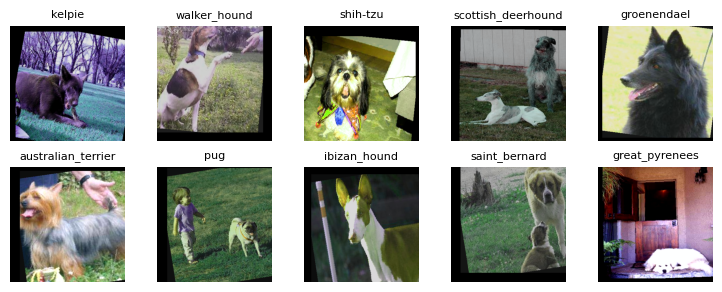

In [23]:
show_first_images(train_dataset, num_images=10, cols=5, scale=1.5)

## Data Loaders

In [24]:


BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"Train loader: {len(train_loader)} batches of size {BATCH_SIZE}")
print(f"Val loader: {len(val_loader)} batches of size {BATCH_SIZE}")
print(f"Test loader: {len(test_loader)} batches of size {BATCH_SIZE}")

Train loader: 256 batches of size 32
Val loader: 64 batches of size 32
Test loader: 324 batches of size 32


In [25]:
# Obtener un batch de entrenamiento
images, labels = next(iter(train_loader))
print(f"Tamaño del batch: {images.shape}")
print(f"Etiquetas: {labels.shape}")


Tamaño del batch: torch.Size([32, 3, 350, 350])
Etiquetas: torch.Size([32])


# Creación de modelos

## Red neuronal personalizada
Esta es una red neuronal convolucional. La estructura es bastante compacta para evitar el sobreajuste y facilitar el entrenamiento rápido. Las partes principales de la red son:
* 3 Bloques:
 - Capa convolucional
 - Normalización y ReLU
 - MaxPool que reduce el tamaño a la mitad

* Luego hacemos un average pooling global que deja una sola salida por canal.
* Clasificador Final:
 - Dropout para mejorar la generalización
 - Fully connected layer para mapear a las razas de los perros

En general lo que hacemos es ir reduciendo progresivamente el tamaño espacial de la imagen (alto y ancho) mientras va aumentando la cantidad de canales.

In [26]:
class Red_propia(nn.Module):

    def __init__(self, num_classes: int, input_channels: int = 3, dropout_rate: float = 0.25):
        super(Red_propia, self).__init__()


        self.features = nn.Sequential(
            # Bloque 1
            nn.Conv2d(input_channels, 64, kernel_size=5, stride=2, padding=2), # reduce el tamaño a la mitad
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),  # reduce el tamaño a la mitad

            # Bloque 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # reduce el tamaño a la mitad

            # Bloque 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1))  # Global average pooling
        )

        # Clasificador
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(256, num_classes)
        )

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

## Constructor de modelos
Definimos una función para manejar la construcción de los diferentes modelos que vamos a evaluar.



In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

def build_model(model_name: str, num_classes: int, device, train_only_fc: bool = True):
    """Construye modelo con mejor inicialización."""
    if device is None:
        device = torch.device("cpu")
    # Red neuronal personalizada
    if model_name == 'red_propia':
        model = Red_propia(num_classes=num_classes, dropout_rate=0.3)

    #ResNet 50
    elif model_name == 'resnet50':
        model = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT)

        # entenamos solo la ultima capa
        if train_only_fc:
            for param in model.parameters():
                param.requires_grad = False

        model.fc = torch.nn.Sequential(
            torch.nn.Dropout(0.5), # para reducir overfitting
            torch.nn.Linear(model.fc.in_features, num_classes)
        )

        torch.nn.init.kaiming_normal_(model.fc[1].weight, mode='fan_out', nonlinearity='relu')
        torch.nn.init.zeros_(model.fc[1].bias)

    #mobilenet_v2
    elif model_name == 'mobilenet_v2':
        model = torchvision.models.mobilenet_v2(weights=torchvision.models.MobileNet_V2_Weights.DEFAULT)

        # entenamos solo la ultima capa
        if train_only_fc:
            for param in model.parameters():
                param.requires_grad = False

        model.classifier = torch.nn.Sequential(
            torch.nn.Dropout(0.5),
            torch.nn.Linear(model.last_channel, num_classes)
        )
        torch.nn.init.kaiming_normal_(model.classifier[1].weight)
        torch.nn.init.zeros_(model.classifier[1].bias)

    #densenet121
    elif model_name == 'densenet121':
        model = torchvision.models.densenet121(weights=torchvision.models.DenseNet121_Weights.DEFAULT)

        # entenamos solo la ultima capa
        if train_only_fc:
            for param in model.parameters():
                param.requires_grad = False

        model.classifier = torch.nn.Sequential(
            torch.nn.Dropout(0.5),
            torch.nn.Linear(model.classifier.in_features, num_classes)
        )
        torch.nn.init.kaiming_normal_(model.classifier[1].weight)
        torch.nn.init.zeros_(model.classifier[1].bias)

    return model.to(device)

cuda


### Fine-tuning ResNet 50
Vamos a hacer fine tuning con la red ResNet 50 preentrenada. La red original tiene:

* Conv inicial + BN + ReLU → 1 capa
* 4 grupos de bloques con:
 * 3 + 4 + 6 + 3 bloques residuales (reducen el tamaño de la entrada → la procesan → aumentan el tamaño para que la salida tenga el mismo tamaño que la entrada)
   * Cada bloque tiene 3 capas convolucionales → total = 3×(3+4+6+3) = 48
   * En los grupos de bloques 1,3 y 4 hace un downsampling reduciendo el tamaño de la salida y aumentando la cantidad de canales para capturar más características.
* Más la capa fully connected final → 1 capa


La última capa de la red, es la que vamos a reemplazar por una nueva capa que vamos a tener que entrenar desde cero. Esta capa tendrá las mismas entradas que la FC original y 120 salidas que son la cantidad de razas de perros del Dataset.

Esta red es más pesada y lenta que por ejemplo la MobileNet V2 pero tiene mayor precisión.
Elegimos probar esta red por su precisión en la clasificación.

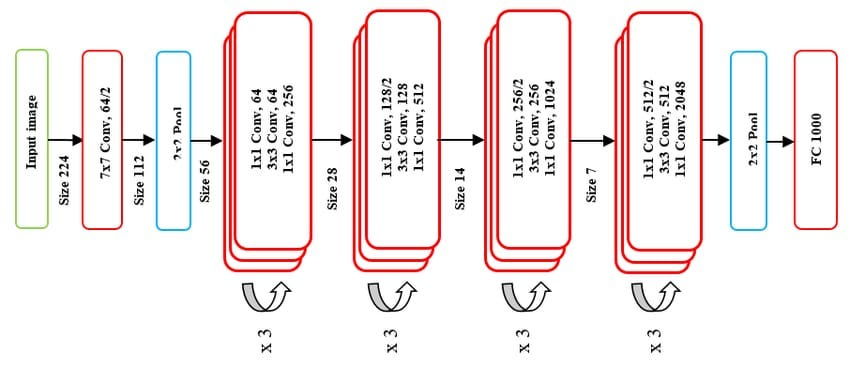

In [28]:
resNet50_tune = build_model('resnet50',120,device)
print(resNet50_tune)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### MobileNet V2
Es una red neuronal liviana y rápida, es decir que no necesita muchos recursos.
Esta red en lugar de usar convoluciones 2D usa  Depthwise Separable Convolutions lo que reduce mucho el cómputo  que son una combinación de:
* Depthwise convolution: aplica un Kernel 3x3 por cada canal de la entrada
* Pointwise convolution: aplica un Kernel 1x1 para mezclar los canales y generar las salidas necesarias

Los bloques de la red son InvertedResidual, estos bloques expanden la entrada → la procesan → la reducen al mismo tamaño de la entrada.

* Una expansión (convolución 1x1) para aumentar canales.
* Una depthwise convolution.
* Una proyección lineal (otra 1x1) que reduce los canales de nuevo

Se elige probar esta red por su eficiencia en el uso de recursos, velocidad de clasificación y rendimiento en clasificación.

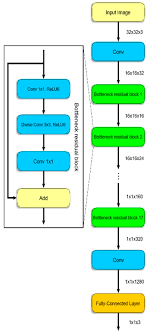


In [29]:
mobileNetV2_tune= build_model('mobilenet_v2',120, device)
print(mobileNetV2_tune)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

##DenseNet-121
DenseNet es una red popular que, a diferencia de otras como ResNet, no solo conecta una capa con la siguiente, sino que la salida de cada bloque se concatena con las salidas de todas las capas anteriores. Por eso se le llama una red densamente conectada.

Esta característica permite que cada capa tenga acceso a toda la información que ya se aprendió anteriormente, lo que hace que la red pueda aprender más fácilmente. En lugar de repetir el mismo tipo de características, cada capa puede enfocarse en aprender cosas nuevas y complementar lo que ya se extrajo antes.

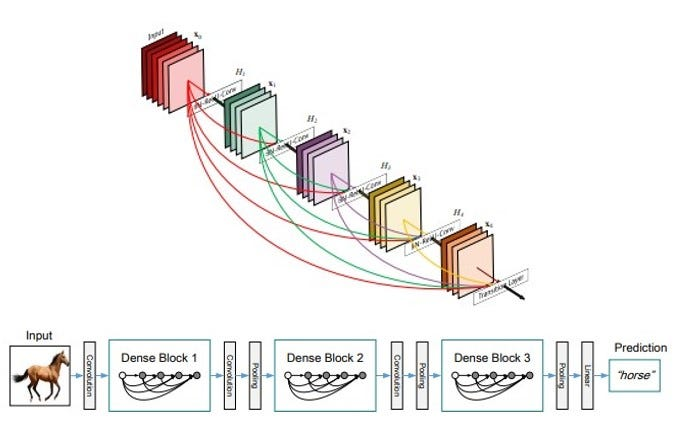

In [30]:
densenet121= build_model('densenet121',120, device)
print(densenet121)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

## Entrenamiento y metricas de los modelos

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from torch.optim.lr_scheduler import ReduceLROnPlateau

def train_model(model, train_loader, val_loader, num_epochs=100):
    """
    Entrena el modelo final por muchas épocas y registra métricas.
    """
    # Configurar optimizador
    optimizer = optim.AdamW(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=0.001,
        weight_decay=1e-4
    )

    # Configurar scheduler de learning rate
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)


    # Función de pérdida
    l = nn.CrossEntropyLoss()

    # Listas para guardar métricas
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    last_epoch_class_accuracies = {} # Diccionario para guardar las precisiones por clase de la última época


    print(f"Iniciando entrenamiento por {num_epochs} épocas...")
    # train
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad()
            y_hat = model(x)
            loss = l(y_hat, y)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(y_hat.data, 1)
            train_total += y.size(0)
            train_correct += (predicted == y).sum().item()

        # validación
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        class_correct = list(0. for i in range(len(val_loader.dataset.breeds)))
        class_total = list(0. for i in range(len(val_loader.dataset.breeds)))


        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                y_hat = model(x)
                val_loss += l(y_hat, y).item()

                _, predicted = torch.max(y_hat.data, 1)
                val_total += y.size(0)
                val_correct += (predicted == y).sum().item()


                # Calculate per-class accuracy during validation for the last epoch
                if epoch == num_epochs - 1:
                  c = (predicted == y).squeeze()
                  for i in range(y.size(0)):
                      label = y[i]
                      class_correct[label] += c[i].item()
                      class_total[label] += 1


        # Calculo métricas
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        train_acc = 100. * train_correct / train_total
        val_acc = 100. * val_correct / val_total

        # Guardar métricas
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        # Guardar accuracy de cada raza en la ultima epoch
        if epoch == num_epochs - 1:
          for i in range(len(val_loader.dataset.breeds)):
              if class_total[i] > 0:
                  accuracy = 100 * class_correct[i] / class_total[i]
                  last_epoch_class_accuracies[val_loader.dataset.breeds[i]] = accuracy
              else:
                  last_epoch_class_accuracies[val_loader.dataset.breeds[i]] = 0.0 # por si alguna clase no tiene imágnes


        # Mostrar resultados de la época
        print(f'Época {epoch+1}/{num_epochs} - Loss: {train_loss:.4f} - Train Acc: {train_acc:.2f}% - Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.2f}%')


    print("\n=== ENTRENAMIENTO COMPLETADO ===")
    return model, train_losses, val_losses, train_accuracies, val_accuracies, last_epoch_class_accuracies


def plot_metrics(train_metrics, val_metrics, metric_name):
    epochs = range(1, len(train_metrics) + 1)
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_metrics, 'bo-', label=f'Training {metric_name}')
    plt.plot(epochs, val_metrics, 'ro-', label=f'Validation {metric_name}')
    plt.title(f'Training and Validation {metric_name} per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_multiple_validation_accuracies(model_accuracies):
    plt.figure(figsize=(10, 6))
    for model_name, accuracies in model_accuracies.items():
        epochs = range(1, len(accuracies) + 1)
        plt.plot(epochs, accuracies, marker='o', linestyle='-', label=model_name)

    plt.title('Comparación val_accuracy por modelo')
    plt.xlabel('Epochs')
    plt.ylabel('Validation Accuracy (%)')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_top_bottom_breeds_accuracy(last_epoch_class_accuracies, n=10):
    accuracy_df = pd.DataFrame.from_dict(last_epoch_class_accuracies, orient='index', columns=['Accuracy'])
    accuracy_df = accuracy_df.sort_values(by='Accuracy', ascending=False)

    # Obtener las N mejor y las N peores
    top_n_breeds = accuracy_df.head(n)
    bottom_n_breeds = accuracy_df.tail(n)

    # Mostrar las N mejores predicciones de raza
    plt.figure(figsize=(10, 6))
    plt.barh(top_n_breeds.index, top_n_breeds['Accuracy'], color='skyblue')
    plt.xlabel('Accuracy (%)')
    plt.title(f'Top {n} Best Performing Breeds (Last Epoch)')
    plt.gca().invert_yaxis()  # Invert y-axis to show the highest accuracy at the top
    plt.show()

    # Mostrar las N peores predicciones de raza
    plt.figure(figsize=(10, 6))
    plt.barh(bottom_n_breeds.index, bottom_n_breeds['Accuracy'], color='salmon')
    plt.xlabel('Accuracy (%)')
    plt.title(f'Bottom {n} Worst Performing Breeds (Last Epoch)')
    plt.gca().invert_yaxis()
    plt.show()

# Validación de Modelos

In [ ]:
BATCH_SIZE = 32
NUM_CLASSES = 120
# Crear datasets
train_dataset, val_dataset, test_dataset = datasetsCration(
    seed=45,
    resizeHeight=224,
    resizeWidth=224,
    normalizeMean=[0.485, 0.456, 0.406],
    normalizeStd=[0.229, 0.224, 0.225],
    val_ratio=0.2
)
# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

### Validación Resnet 50

In [ ]:
#Creando modelo resnet50
model_resnet50 = build_model('resnet50', NUM_CLASSES, device, train_only_fc=True)

Iniciando entrenamiento por 25 épocas...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Época 1/25 - Loss: 5.1160 - Train Acc: 7.30% - Val Loss: 2.7869 - Val Acc: 35.08%
Época 2/25 - Loss: 3.0800 - Train Acc: 27.88% - Val Loss: 1.6624 - Val Acc: 60.76%
Época 3/25 - Loss: 2.2499 - Train Acc: 44.02% - Val Loss: 1.1639 - Val Acc: 70.55%
Época 4/25 - Loss: 1.8138 - Train Acc: 53.06% - Val Loss: 0.9237 - Val Acc: 76.13%
Época 5/25 - Loss: 1.5469 - Train Acc: 58.87% - Val Loss: 0.8110 - Val Acc: 78.47%
Época 6/25 - Loss: 1.3761 - Train Acc: 62.91% - Val Loss: 0.7273 - Val Acc: 79.21%
Época 7/25 - Loss: 1.2707 - Train Acc: 65.68% - Val Loss: 0.6847 - Val Acc: 80.77%
Época 8/25 - Loss: 1.1751 - Train Acc: 67.64% - Val Loss: 0.6767 - Val Acc: 81.31%
Época 9/25 - Loss: 1.0680 - Train Acc: 70.09% - Val Loss: 0.6543 - Val Acc: 81.16%
Época 10/25 - Loss: 1.0328 - Train Acc: 71.04% - Val Loss: 0.6300 - Val Acc: 81.95%
Época 11/25 - Loss: 0.9813 - Train Acc: 71.92% - Val Loss: 0.6105 - Val Acc: 81.41%
Época 12/25 - Loss: 0.9411 - Train Acc: 72.89% - Val Loss: 0.6020 - Val Acc: 81.75%
Ép

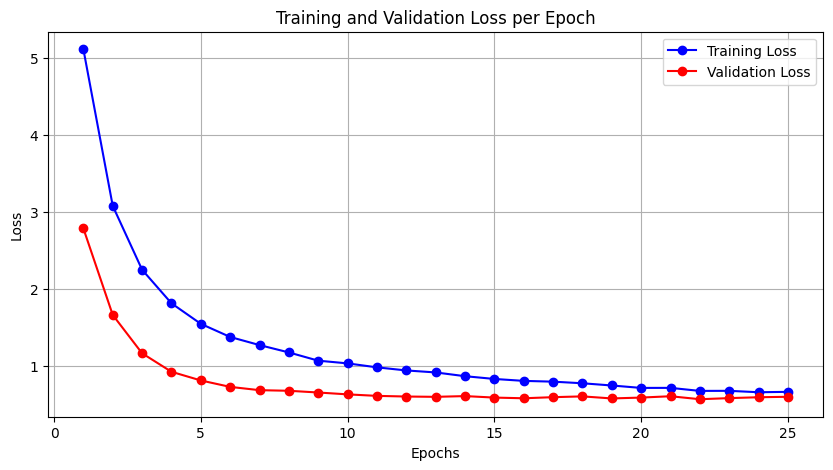

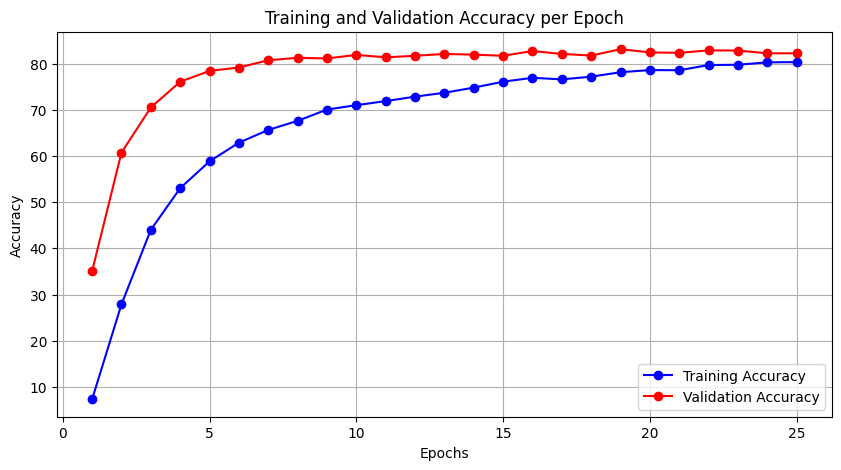

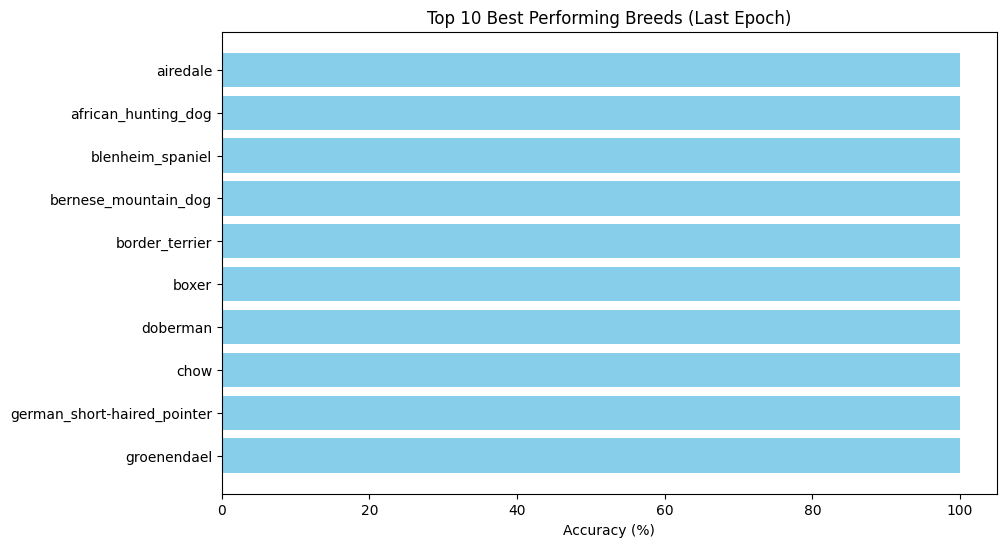

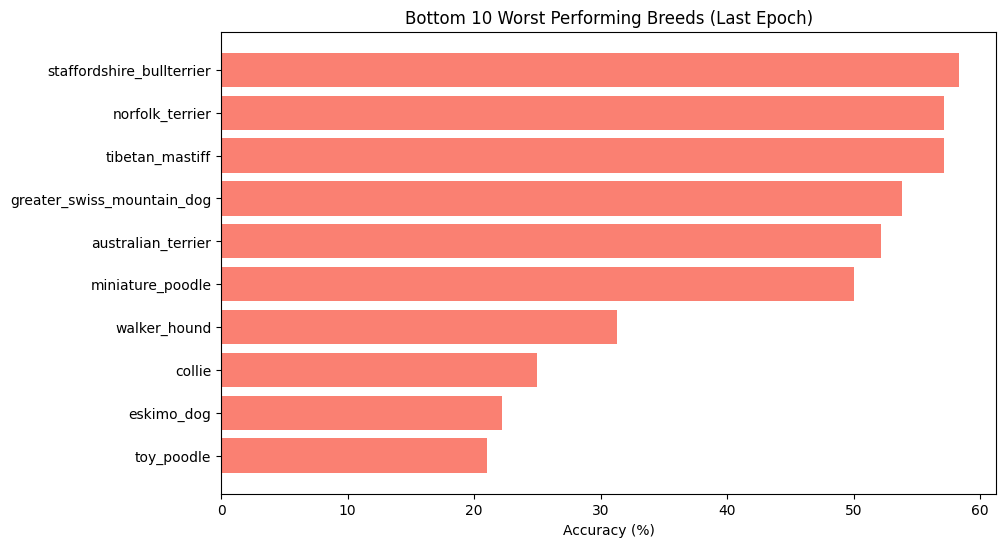

In [ ]:
model_resnet50, train_losses_resnet50, val_losses_resnet50, train_accuracies_resnet50, val_accuracies_resnet50, last_epoch_class_accuracies_resnet50 = train_model(
    model=model_resnet50,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=25
)

plot_metrics(train_losses_resnet50, val_losses_resnet50, 'Loss')
plot_metrics(train_accuracies_resnet50, val_accuracies_resnet50, 'Accuracy')
plot_top_bottom_breeds_accuracy(last_epoch_class_accuracies_resnet50,10)

### Validación Red propia

In [ ]:
 # Crear modelo red_propia
model_red_propia = build_model('red_propia', NUM_CLASSES, device, train_only_fc=False)

Iniciando entrenamiento por 25 épocas...
Época 1/25 - Loss: 4.7870 - Train Acc: 1.19% - Val Loss: 4.7328 - Val Acc: 1.52%
Época 2/25 - Loss: 4.7131 - Train Acc: 1.90% - Val Loss: 4.7133 - Val Acc: 2.30%
Época 3/25 - Loss: 4.6789 - Train Acc: 2.37% - Val Loss: 4.6790 - Val Acc: 2.25%
Época 4/25 - Loss: 4.6427 - Train Acc: 2.62% - Val Loss: 4.6458 - Val Acc: 3.38%
Época 5/25 - Loss: 4.6072 - Train Acc: 2.74% - Val Loss: 4.6750 - Val Acc: 3.57%
Época 6/25 - Loss: 4.5519 - Train Acc: 3.60% - Val Loss: 4.5854 - Val Acc: 4.01%
Época 7/25 - Loss: 4.5077 - Train Acc: 3.88% - Val Loss: 4.5544 - Val Acc: 4.01%
Época 8/25 - Loss: 4.4724 - Train Acc: 4.08% - Val Loss: 4.5570 - Val Acc: 4.21%
Época 9/25 - Loss: 4.4259 - Train Acc: 4.67% - Val Loss: 4.4275 - Val Acc: 5.19%
Época 10/25 - Loss: 4.3882 - Train Acc: 4.81% - Val Loss: 4.4410 - Val Acc: 4.21%
Época 11/25 - Loss: 4.3591 - Train Acc: 4.88% - Val Loss: 4.4467 - Val Acc: 5.38%
Época 12/25 - Loss: 4.3175 - Train Acc: 5.43% - Val Loss: 4.7176 -

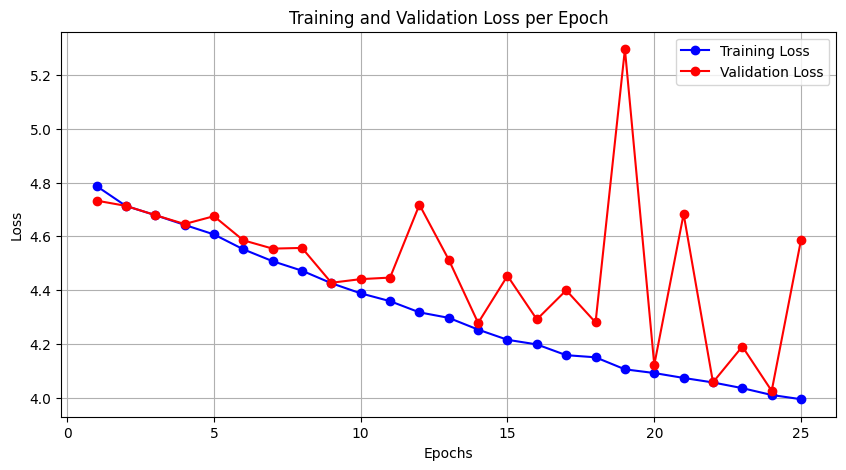

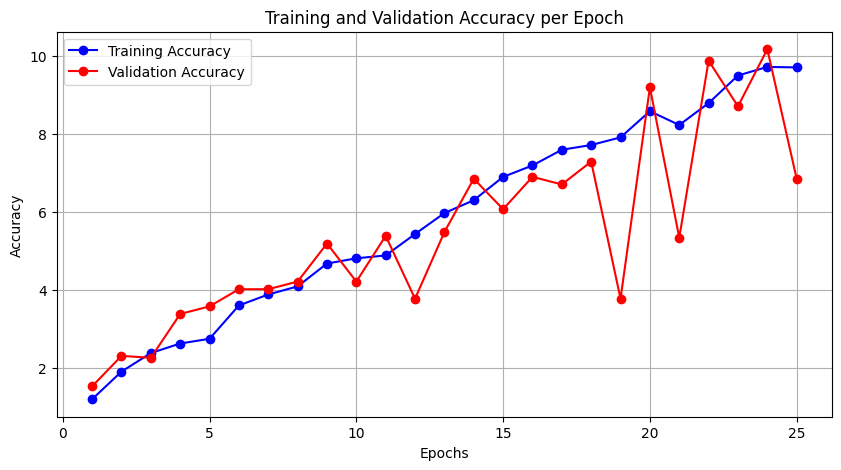

In [ ]:
model_red_propia, train_losses_red_propia, val_losses_red_propia, train_accuracies_red_propia, val_accuracies_red_propia, last_epoch_class_accuracies_red_propia = train_model(
    model=model_red_propia,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=25
)

plot_metrics(train_losses_red_propia, val_losses_red_propia, 'Loss')
plot_metrics(train_accuracies_red_propia, val_accuracies_red_propia, 'Accuracy')

### Validación MobileNet V2

In [ ]:
 # Crear modelo densenet121
model_mobilenetv2 = build_model('mobilenet_v2', NUM_CLASSES, device, train_only_fc=True)

Iniciando entrenamiento por 25 épocas...
Época 1/25 - Loss: 3.6836 - Train Acc: 19.15% - Val Loss: 2.4874 - Val Acc: 47.95%
Época 2/25 - Loss: 2.4799 - Train Acc: 41.22% - Val Loss: 1.8919 - Val Acc: 56.36%
Época 3/25 - Loss: 2.0622 - Train Acc: 48.03% - Val Loss: 1.6506 - Val Acc: 58.76%
Época 4/25 - Loss: 1.8813 - Train Acc: 52.10% - Val Loss: 1.5348 - Val Acc: 60.18%
Época 5/25 - Loss: 1.7476 - Train Acc: 54.29% - Val Loss: 1.4626 - Val Acc: 61.69%
Época 6/25 - Loss: 1.6580 - Train Acc: 55.69% - Val Loss: 1.3692 - Val Acc: 64.19%
Época 7/25 - Loss: 1.5926 - Train Acc: 57.46% - Val Loss: 1.3409 - Val Acc: 63.65%
Época 8/25 - Loss: 1.5286 - Train Acc: 58.47% - Val Loss: 1.3429 - Val Acc: 62.87%
Época 9/25 - Loss: 1.4840 - Train Acc: 59.07% - Val Loss: 1.3069 - Val Acc: 63.36%
Época 10/25 - Loss: 1.4689 - Train Acc: 59.40% - Val Loss: 1.2698 - Val Acc: 64.19%
Época 11/25 - Loss: 1.4371 - Train Acc: 60.61% - Val Loss: 1.2734 - Val Acc: 63.16%
Época 12/25 - Loss: 1.3995 - Train Acc: 61.1

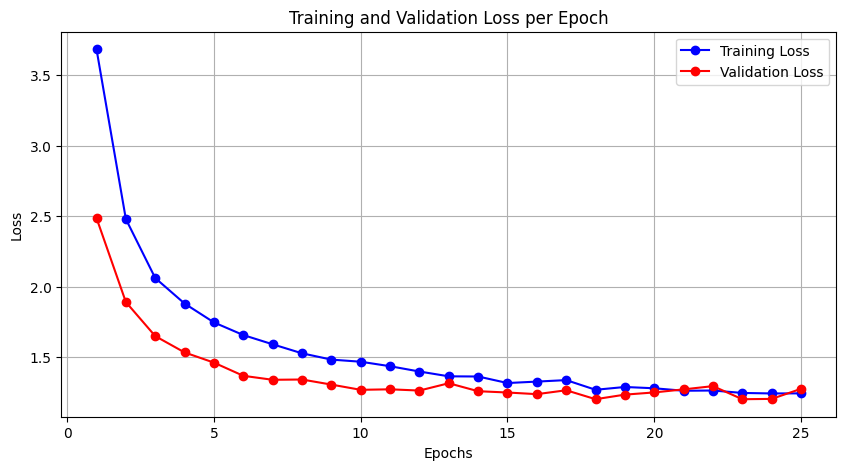

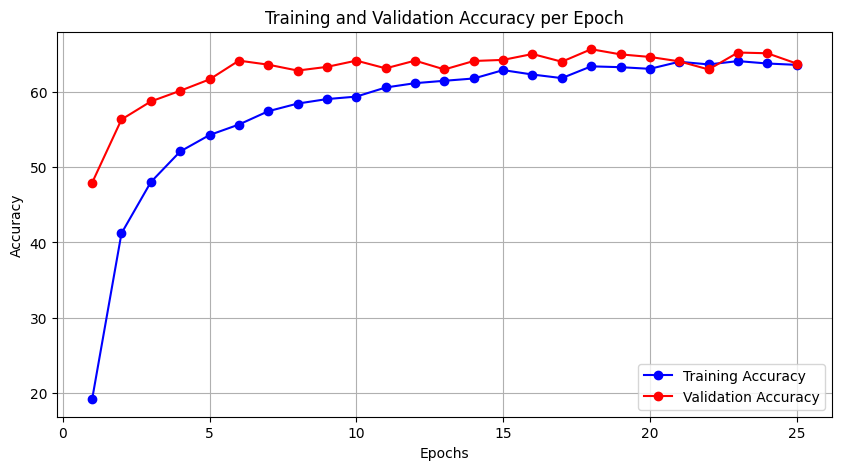

In [ ]:
model_mobilenetv2, train_losses_mobilenetv2, val_losses_mobilenetv2, train_accuracies_mobilenetv2, val_accuracies_mobilenetv2, last_epoch_class_accuracies_mobilenetv2 = train_model(
    model=model_mobilenetv2,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=25
)

plot_metrics(train_losses_mobilenetv2, val_losses_mobilenetv2, 'Loss')
plot_metrics(train_accuracies_mobilenetv2, val_accuracies_mobilenetv2, 'Accuracy')

### Validación DesneNet 121

In [ ]:
 # Crear modelo densenet121
model_densenet121 = build_model('densenet121', NUM_CLASSES, device, train_only_fc=True)

Iniciando entrenamiento por 25 épocas...
Época 1/25 - Loss: 4.2064 - Train Acc: 12.42% - Val Loss: 2.3095 - Val Acc: 49.46%
Época 2/25 - Loss: 2.6184 - Train Acc: 33.69% - Val Loss: 1.5820 - Val Acc: 62.57%
Época 3/25 - Loss: 2.1523 - Train Acc: 42.76% - Val Loss: 1.3312 - Val Acc: 65.61%
Época 4/25 - Loss: 1.9145 - Train Acc: 48.12% - Val Loss: 1.1679 - Val Acc: 68.40%
Época 5/25 - Loss: 1.7743 - Train Acc: 51.30% - Val Loss: 1.0993 - Val Acc: 69.37%
Época 6/25 - Loss: 1.6973 - Train Acc: 53.00% - Val Loss: 1.0669 - Val Acc: 70.11%
Época 7/25 - Loss: 1.6341 - Train Acc: 54.37% - Val Loss: 1.0214 - Val Acc: 71.92%
Época 8/25 - Loss: 1.6077 - Train Acc: 55.89% - Val Loss: 0.9952 - Val Acc: 72.31%
Época 9/25 - Loss: 1.5480 - Train Acc: 56.10% - Val Loss: 0.9596 - Val Acc: 72.50%
Época 10/25 - Loss: 1.5537 - Train Acc: 56.76% - Val Loss: 0.9873 - Val Acc: 71.38%
Época 11/25 - Loss: 1.5245 - Train Acc: 56.91% - Val Loss: 0.9574 - Val Acc: 72.95%
Época 12/25 - Loss: 1.5073 - Train Acc: 57.1

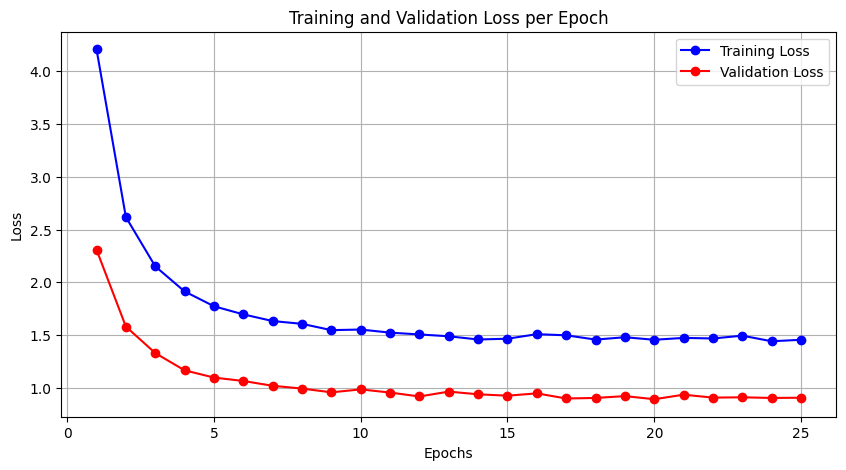

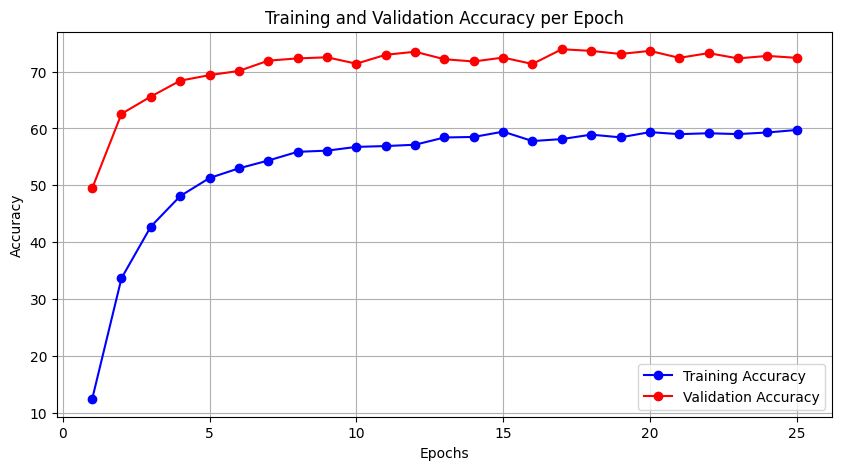

In [ ]:
model_densenet121, train_losses_densenet121, val_losses_densenet121, train_accuracies_densenet121, val_accuracies_densenet121, last_epoch_class_accuracies_densenet121 = train_model(
    model=model_densenet121,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=25
)

plot_metrics(train_losses_densenet121, val_losses_densenet121, 'Loss')
plot_metrics(train_accuracies_densenet121, val_accuracies_densenet121, 'Accuracy')

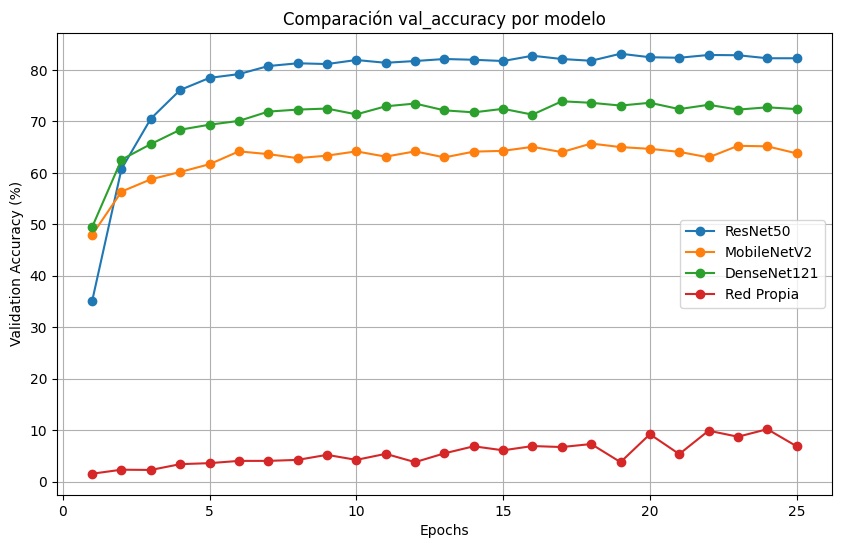

In [ ]:
model_accuracies_for_plotting = {
    'ResNet50': val_accuracies_resnet50,
    'MobileNetV2': val_accuracies_mobilenetv2,
    'DenseNet121': val_accuracies_densenet121,
    'Red Propia': val_accuracies_red_propia
}

plot_multiple_validation_accuracies(model_accuracies_for_plotting)

# Selección del Modelo

## Elección - Resnet 50
A partir del análisis de los resultados k folds cv el modelo elegido es **resnet 50** que obtuvo las mejores métricas
- Train Acc:  80.37%
- Valid Acc:  82.29%

Por lo tanto es el modelo que vamos a entrenar a continuación y el que vamos a usar para la clasificación de razas de perros.

# Entrenamiento del modelo

## Guardado y carga de los pesos del modelo

In [32]:
def save_model(model, path='resnet50_model.pth'):
    """Guarda los pesos del modelo."""
    torch.save(model.state_dict(), path)
    print(f"Modelo guardado en: {path}")

# Function to load the model weights
def load_model(model, path):
    """Loads the model weights from a specified path."""
    try:
        model.load_state_dict(torch.load(path, map_location=device))
        print(f"Model weights loaded successfully from: {path}")
    except FileNotFoundError:
        print(f"Error: Model file not found at {path}")
    except Exception as e:
        print(f"An error occurred while loading the model: {e}")

def download_model(model, path):
  from google.colab import files
  files.download("resnet50_model.pth")



## Entrenamiento

In [33]:
BATCH_SIZE = 32
NUM_CLASSES = 120
# Crear datasets
train_dataset, val_dataset, test_dataset = datasetsCration(
    seed=45,
    resizeHeight=224,  # DenseNet funciona bien con 224x224
    resizeWidth=224,
    normalizeMean=[0.485, 0.456, 0.406],  # ImageNet means
    normalizeStd=[0.229, 0.224, 0.225],   # ImageNet stds
    val_ratio=0.2
)
# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [34]:
model = build_model('resnet50', NUM_CLASSES, device, train_only_fc=True)

In [36]:
#Carga de pesos del modelo
from google.colab import files
uploaded = files.upload()
model_path_local = 'resnet50_model.pth'
load_model(model, model_path_local)

Saving resnet50_model.pth to resnet50_model.pth
Model weights loaded successfully from: resnet50_model.pth


Iniciando entrenamiento por 50 épocas...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Época 1/50 - Loss: 0.3285 - Train Acc: 89.72% - Val Loss: 0.5718 - Val Acc: 83.76%
Época 2/50 - Loss: 0.3304 - Train Acc: 89.50% - Val Loss: 0.5671 - Val Acc: 83.51%
Época 3/50 - Loss: 0.3307 - Train Acc: 89.41% - Val Loss: 0.5680 - Val Acc: 84.20%
Época 4/50 - Loss: 0.3422 - Train Acc: 88.90% - Val Loss: 0.5943 - Val Acc: 83.61%
Época 5/50 - Loss: 0.3050 - Train Acc: 90.39% - Val Loss: 0.5989 - Val Acc: 83.22%
Época 6/50 - Loss: 0.3116 - Train Acc: 89.91% - Val Loss: 0.5829 - Val Acc: 83.90%
Época 7/50 - Loss: 0.3007 - Train Acc: 90.85% - Val Loss: 0.5793 - Val Acc: 83.71%
Época 8/50 - Loss: 0.3048 - Train Acc: 90.33% - Val Loss: 0.5816 - Val Acc: 84.00%
Época 9/50 - Loss: 0.2793 - Train Acc: 91.09% - Val Loss: 0.6064 - Val Acc: 83.41%
Época 10/50 - Loss: 0.2828 - Train Acc: 90.95% - Val Loss: 0.5854 - Val Acc: 83.90%
Época 11/50 - Loss: 0.2586 - Train Acc: 91.59% - Val Loss: 0.5907 - Val Acc: 83.02%
Época 12/50 - Loss: 0.2705 - Train Acc: 91.42% - Val Loss: 0.5890 - Val Acc: 83.27%
É

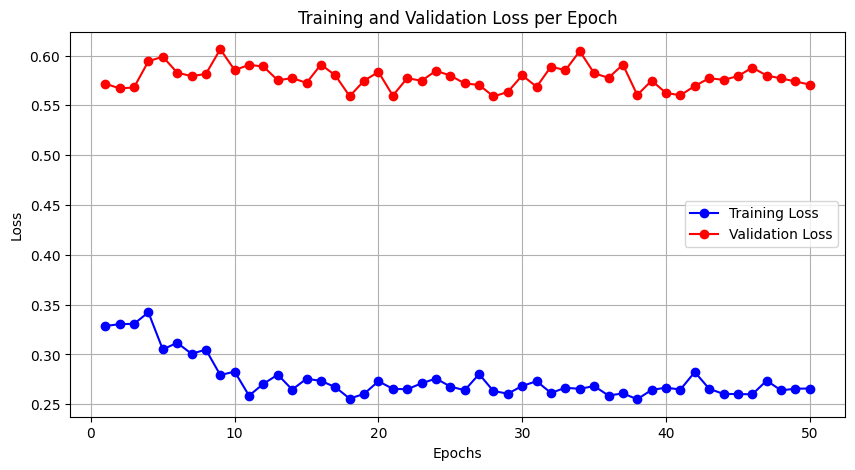

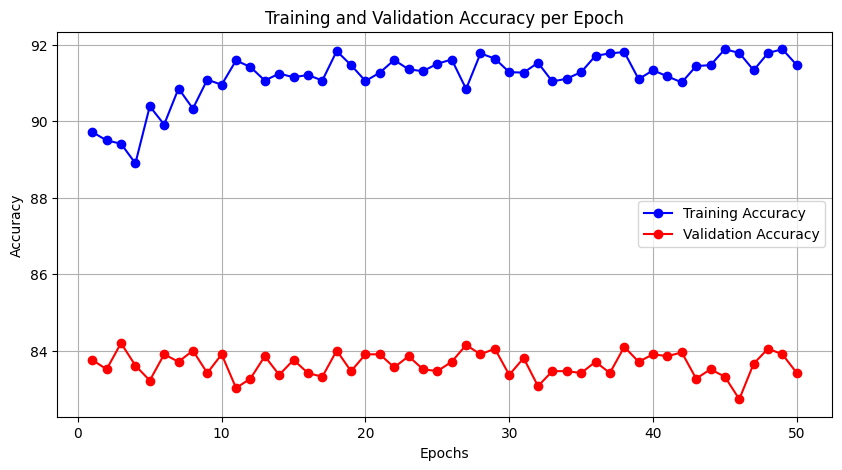

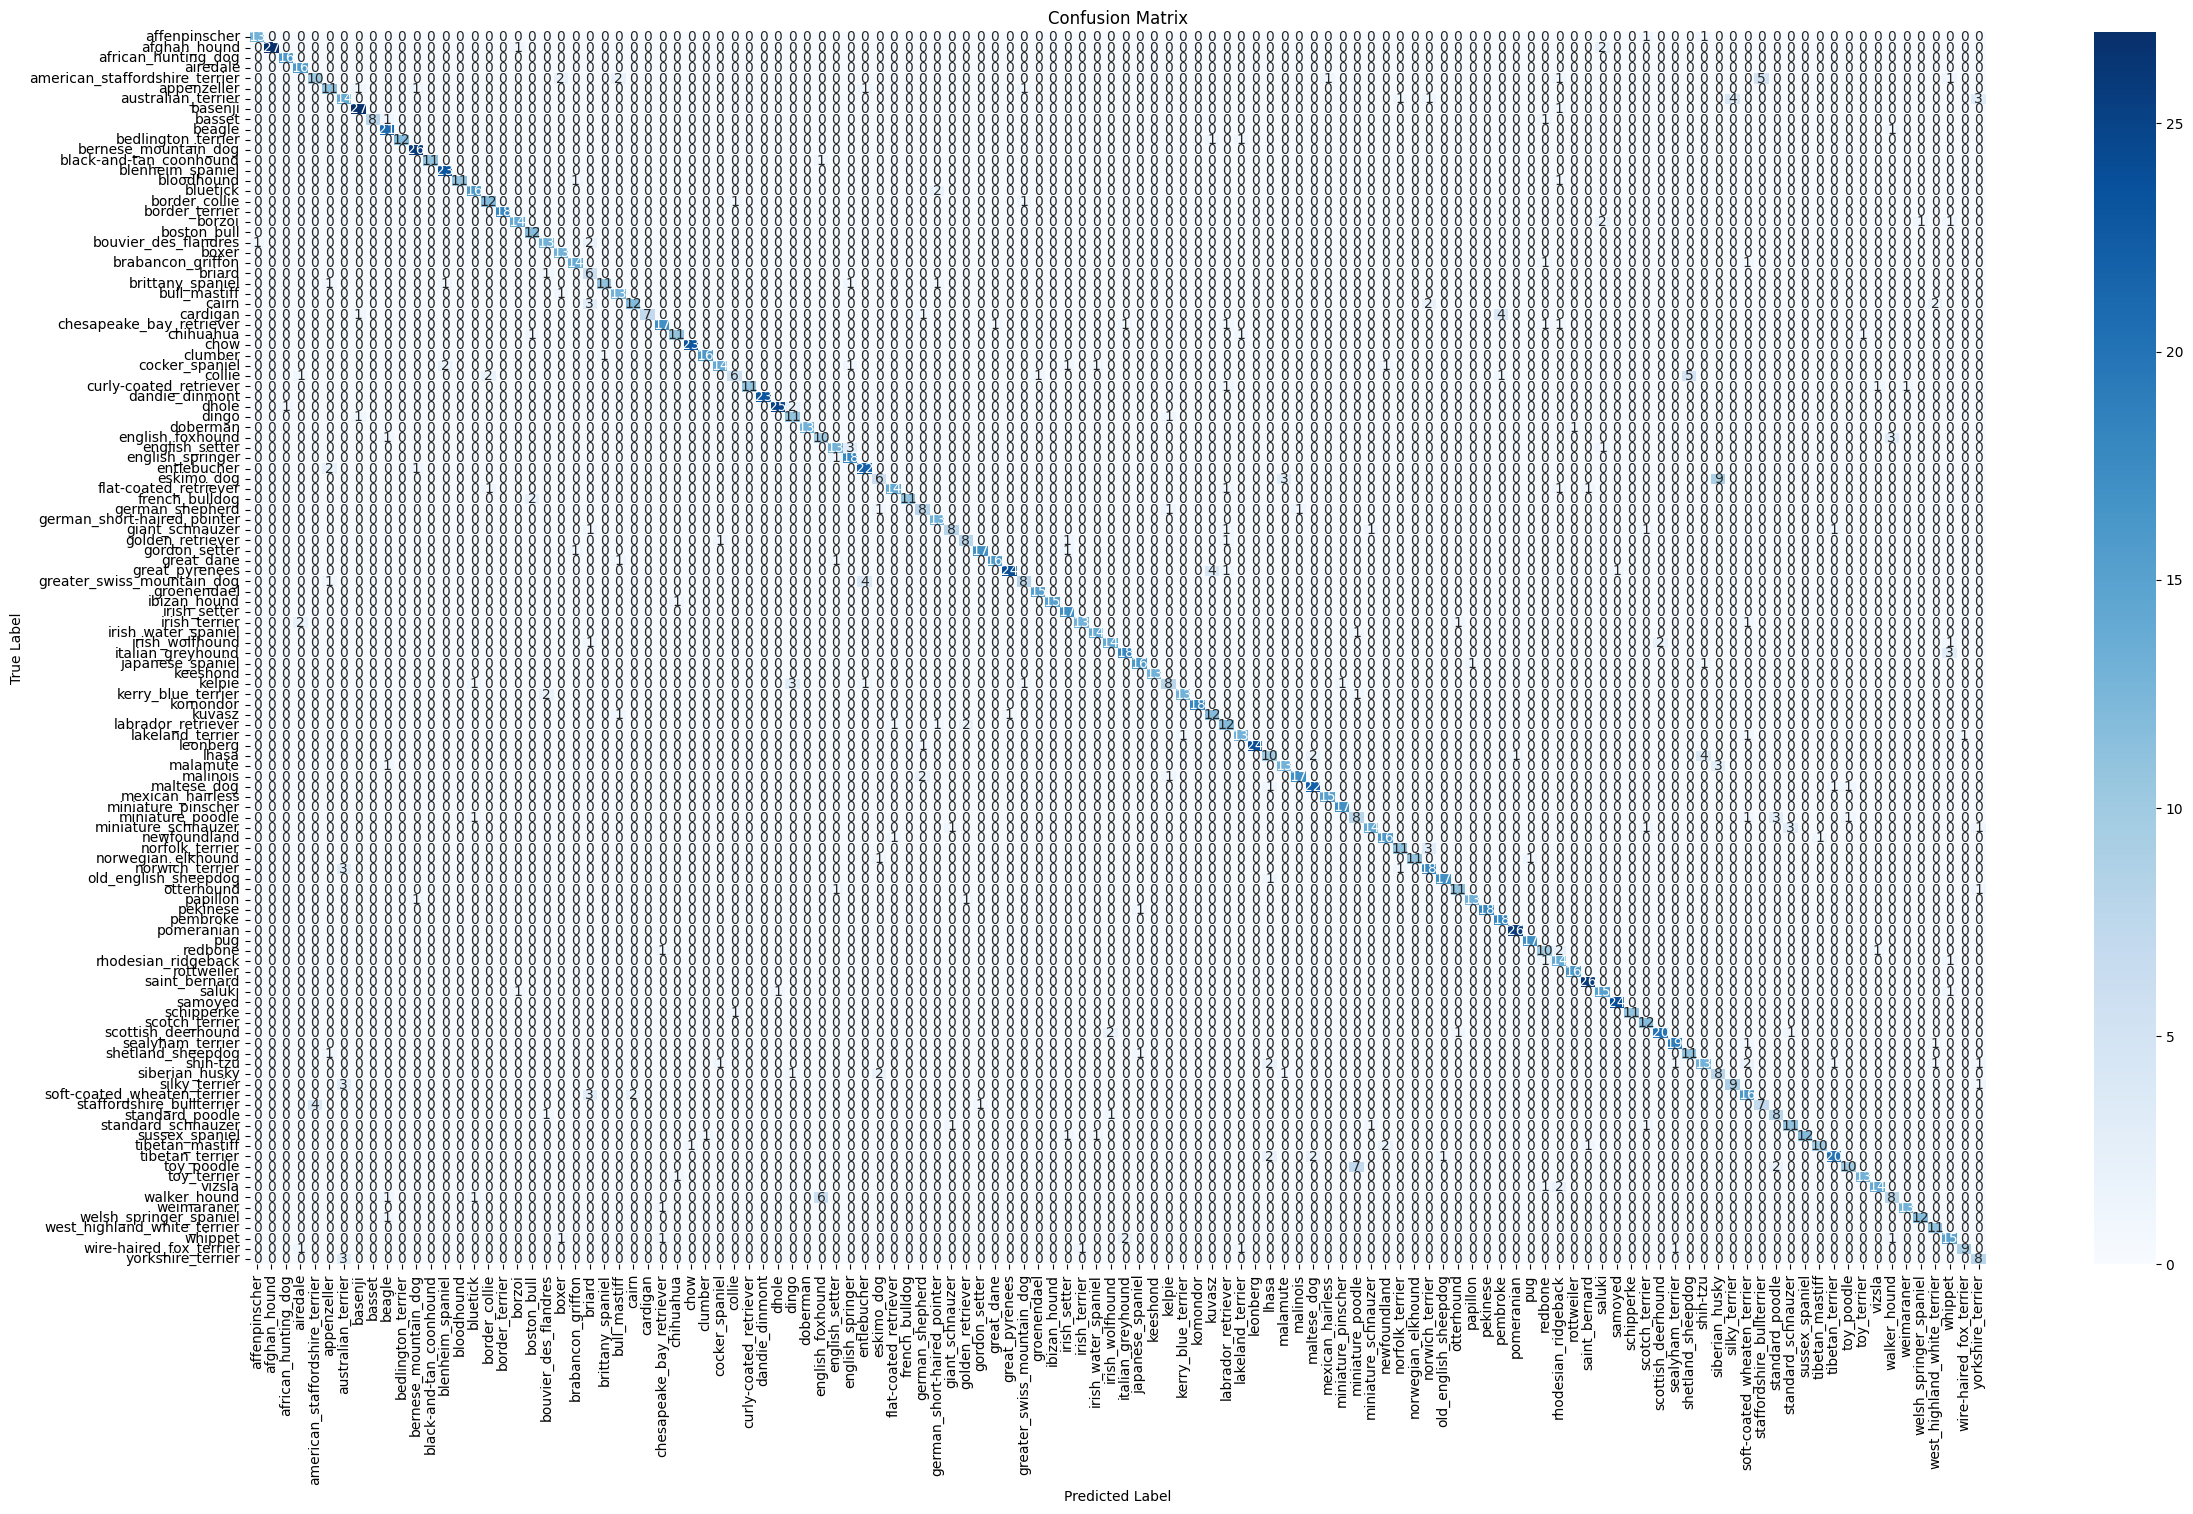

In [ ]:
model_resnet50, train_losses_resnet50, val_losses_resnet50, train_accuracies_resnet50, val_accuracies_resnet50, last_epoch_class_accuracies_resnet50 = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=50
)


Iniciando entrenamiento por 1 épocas...
Época 1/1 - Loss: 0.6498 - Train Acc: 81.19% - Val Loss: 0.6259 - Val Acc: 82.39%

=== ENTRENAMIENTO COMPLETADO ===


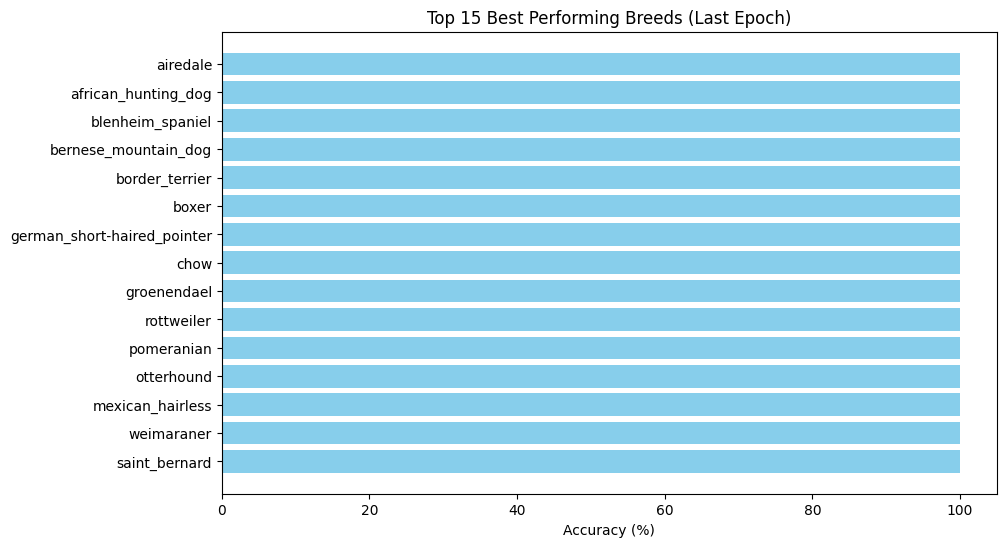

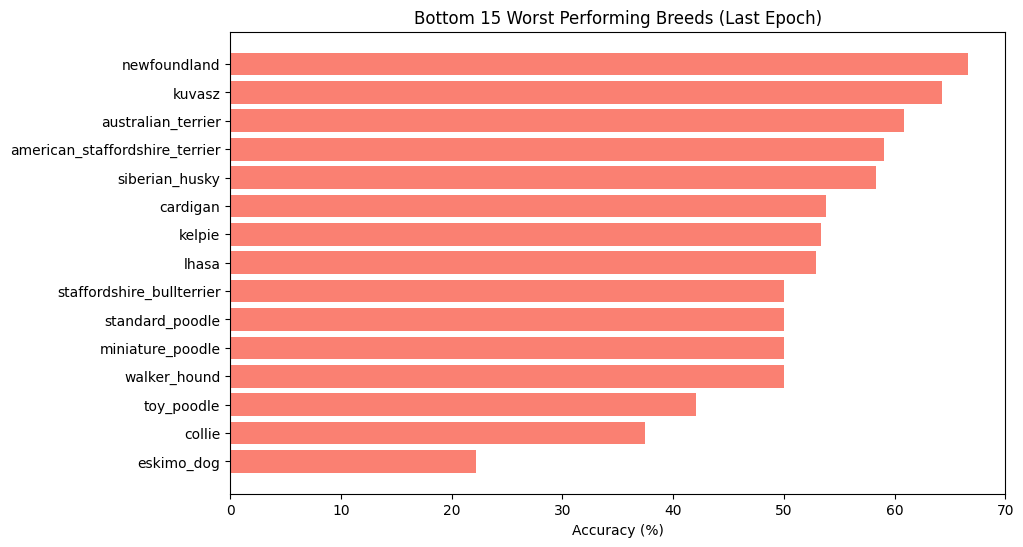

In [39]:
plot_top_bottom_breeds_accuracy(last_epoch_class_accuracies_resnet50,15)

In [ ]:
# Guardar modelo
save_model(model, 'resnet50_model.pth')


Modelo guardado en: resnet50_model.pth


In [ ]:
download_model(model,'resnet50_model.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>